In [45]:
import numpy as np
import numpy.typing as npt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions

In [9]:
df = pd.read_csv("dataset/parkinsons.csv")
df.head()

X = df.drop(["status", "name"], axis=1)
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 42)

X_train

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.03243,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
135,110.453,127.611,105.554,0.00494,0.00004,0.00244,0.00315,0.00731,0.04128,0.379,...,0.03316,0.06688,0.02529,17.707,0.653427,0.706687,-5.333619,0.322044,2.631793,0.228319
122,138.190,203.522,83.340,0.00704,0.00005,0.00406,0.00398,0.01218,0.04479,0.441,...,0.03220,0.07761,0.01968,18.305,0.538016,0.741480,-5.418787,0.160267,2.090438,0.229892
167,260.105,264.919,237.303,0.00339,0.00001,0.00205,0.00186,0.00616,0.02030,0.197,...,0.01367,0.03557,0.00910,21.083,0.440988,0.628058,-7.517934,0.160414,1.881767,0.075587
85,180.978,200.125,155.495,0.00406,0.00002,0.00220,0.00244,0.00659,0.03852,0.331,...,0.02877,0.06321,0.02782,16.176,0.583574,0.727747,-5.657899,0.315903,3.098256,0.200423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,155.078,163.736,144.148,0.00168,0.00001,0.00068,0.00092,0.00204,0.01064,0.097,...,0.00928,0.01567,0.00233,29.746,0.334171,0.677930,-6.981201,0.184550,2.129924,0.106802
14,152.845,163.305,75.836,0.00294,0.00002,0.00121,0.00149,0.00364,0.01828,0.158,...,0.01246,0.03191,0.00609,24.922,0.474791,0.654027,-6.105098,0.203653,2.125618,0.170100
92,148.272,164.989,142.299,0.00459,0.00003,0.00250,0.00256,0.00750,0.04190,0.383,...,0.03051,0.07150,0.01914,18.780,0.454444,0.734504,-5.952058,0.087840,2.344336,0.186489
179,148.143,155.982,135.041,0.00392,0.00003,0.00204,0.00231,0.00612,0.01450,0.131,...,0.01263,0.02175,0.00540,23.683,0.398499,0.778349,-5.711205,0.240875,2.845109,0.192730


In [24]:
def plot_data(X: npt.NDArray, y: npt.NDArray):
	# project points on the 2 first principal components
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)

	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X_scaled)

	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 0.7
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 0.7
		}
	}

	print(X_pca[:,0][0])

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X_pca[:,0][label_indices], 
			X_pca[:,1][label_indices], 
			c=options[label]["color"], 
			label=options[label]["label"], 
			alpha=options[label]["alpha"]
		)

	ax.legend(loc="best")
	ax.set_xlabel("Principal Component 1")
	ax.set_ylabel("Principal Component 2")

	plt.show()

In [57]:
def plot_margins(X: npt.NDArray, y: npt.NDArray, support_vectors: npt.NDArray, clf):
	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 0.7
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 0.7
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X[:,0][label_indices], 
			X[:,1][label_indices], 
			c=options[label]["color"], 
			label=options[label]["label"], 
			alpha=options[label]["alpha"]
		)

	# plot support vectors
	ax.scatter(
		support_vectors[:,0], 
		support_vectors[:,1], 
		c="grey",
		marker="s",
		alpha=0.3,
		label="support vectors"
	)

	# create the meshgrid for the contour decision function
	xx, yy = np.meshgrid(
		np.arange(X[:,0].min() - 1, X[:,0].max() + 1, step=0.1),
		np.arange(X[:,1].min() - 1, X[:,1].max() + 1, step=0.1),
	)

	f = clf.decision_function(np.c_[np.ravel(xx), np.ravel(yy)]).reshape(xx.shape)
	ax.contourf(xx, yy, f, alpha = 0.5)

	#plot_decision_regions(X, y, clf)

	ax.legend(loc="best")
	ax.set_xlabel("principal component 1")
	ax.set_ylabel("principal component 2")

	plt.show()

2.0966143046268098


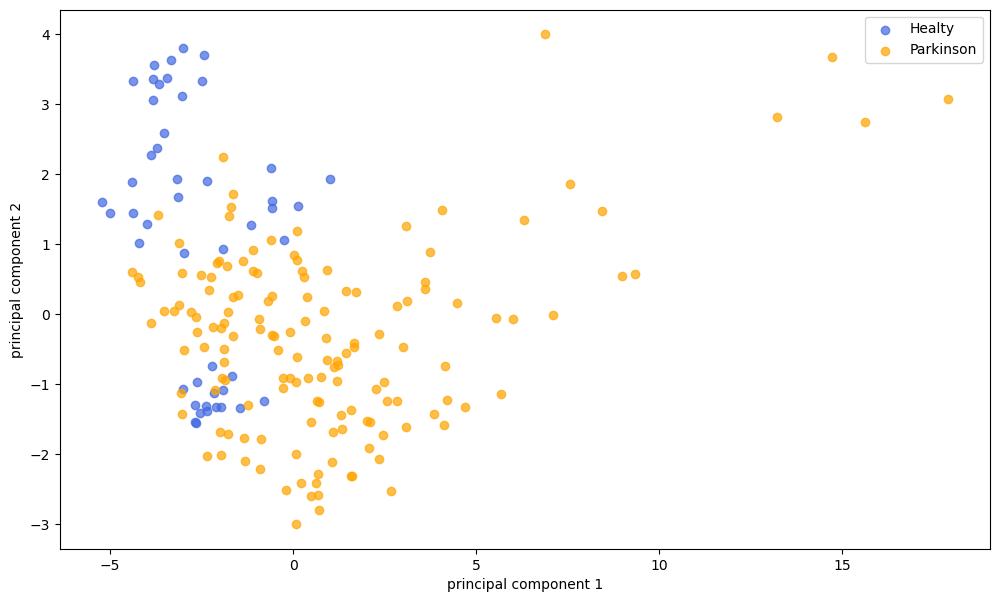

In [20]:
plot_data(X, y)

## Soft Margin SVM

In [27]:
linear_clf = SVC(kernel="linear")
linear_clf.fit(X_train, y_train)

test_score = linear_clf.score(X_test, y_test)

print("----- Linear SVM -----")
print(f"score on testing set: {test_score}")

----- Linear SVM -----
score on testing set: 0.8717948717948718


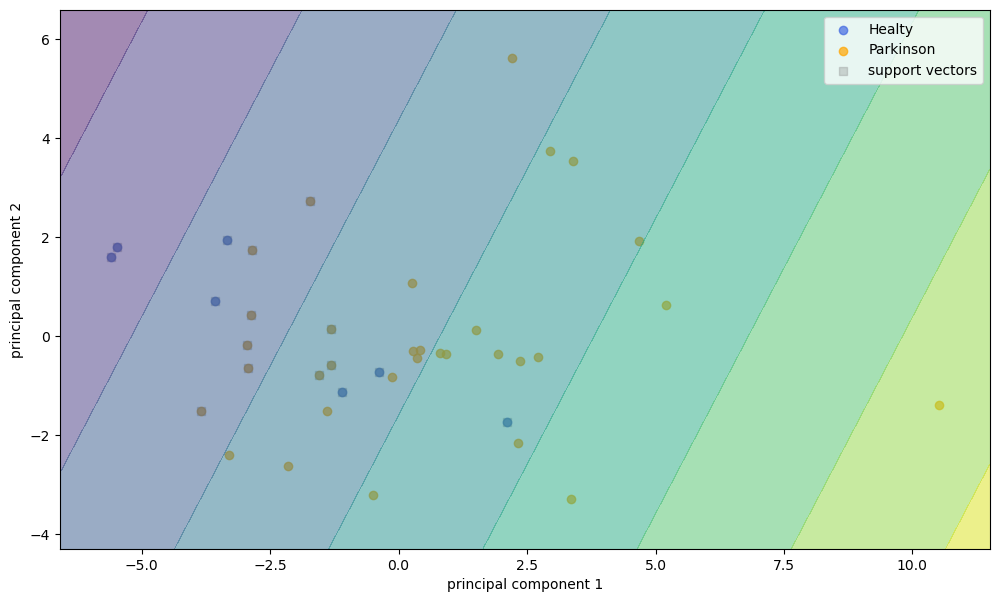

In [58]:
scaler = StandardScaler()
pca = PCA(n_components=2)

X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

linear_clf.fit(X_test_pca, y_test)

plot_margins(X_test_pca, y_test, svm.support_vectors_, linear_clf)

<Axes: >

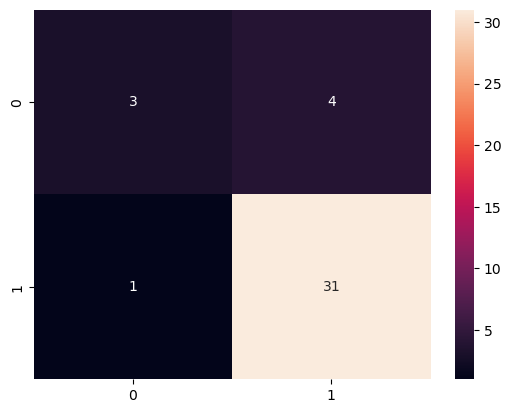

In [37]:
y_pred = linear_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True)

## Hard Margin SVM

In [38]:
kf = KFold(n_splits=5)

hard_margin_params = {
	"C": [7.0, 8.0, 9.0, 10.0, 11.0, 11.5, 12.0, 12.5, 13.0, 14.0, 15.0]
}

gs_hard = GridSearchCV(
	estimator=SVC(kernel="linear"), 
	param_grid=hard_margin_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_hard.fit(X_train, y_train)
val_score = np.round(gs_hard.best_score_, 3)
test_score = np.round(gs_hard.score(X_test, y_test), 3)

print("----- Linear SVM with C Penalty -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_hard.best_params_}")

----- Linear SVM with C Penalty -----
score on validation set: 0.846
score on testing set: 0.897
best params: {'C': 11.0}


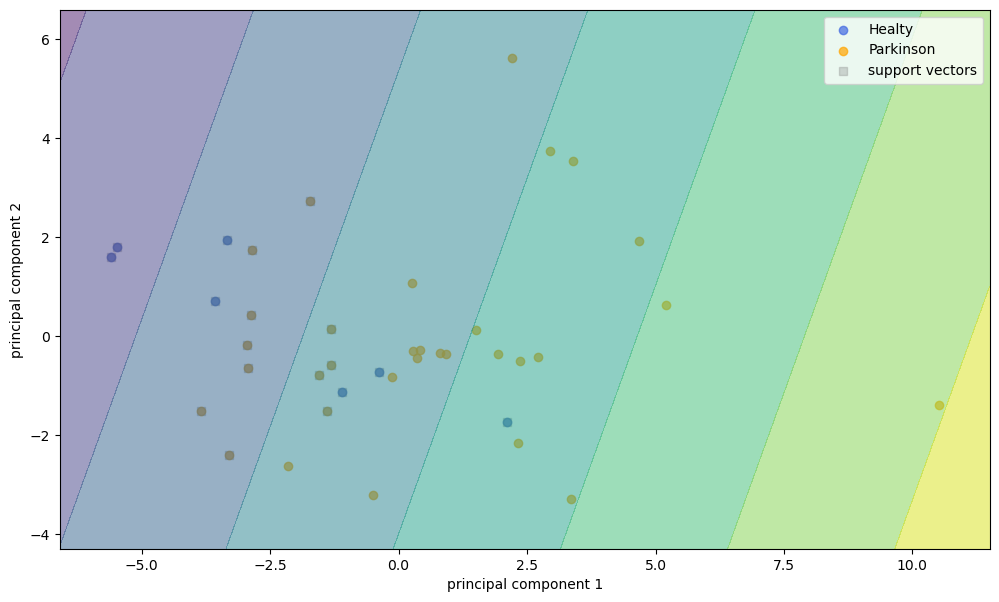

In [59]:
scaler = StandardScaler()
pca = PCA(n_components=2)

X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

svm = SVC(kernel="linear", C=gs_hard.best_params_["C"])
clf = svm.fit(X_test_pca, y_test)

plot_margins(X_test_pca, y_test, svm.support_vectors_, clf)

<Axes: >

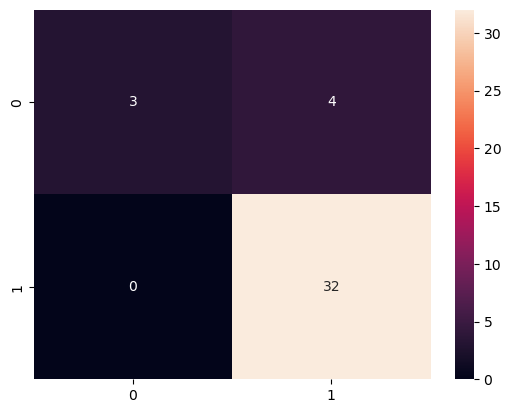

In [42]:
y_pred = gs.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True)

## Kernel Trick

In [61]:
kf = KFold(n_splits=5)

kernel_params = {
	"C": [7.0, 8.0, 9.0, 10.0, 11.0, 11.5, 12.0, 12.5, 13.0, 14.0, 15.0],
	"gamma": [0.001, 0.0015, 0.002, 0.0025, 0.003]
}

gs_kernel = GridSearchCV(
	estimator=SVC(kernel="rbf"), 
	param_grid=kernel_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_kernel.fit(X_train, y_train)
val_score = np.round(gs_kernel.best_score_, 3)
test_score = np.round(gs_kernel.score(X_test, y_test), 3)

print("----- SVM with Kernel Trick -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_kernel.best_params_}")

----- SVM with Kernel Trick -----
score on validation set: 0.897
score on testing set: 0.821
best params: {'C': 12.0, 'gamma': 0.002}


Let's try our svm model on the testing set and plot the results on the 2 first principal components.

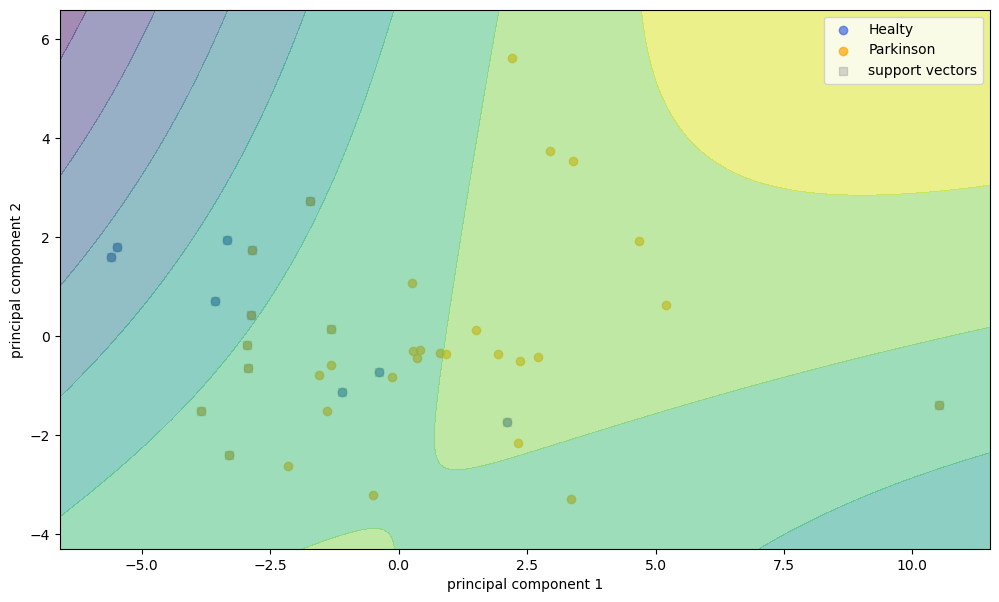

In [62]:
scaler = StandardScaler()
pca = PCA(n_components=2)

X_test_scaled = scaler.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)

svm = SVC(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"])
clf = svm.fit(X_test_pca, y_test)

plot_margins(X_test_pca, y_test, svm.support_vectors_, clf)

<Axes: >

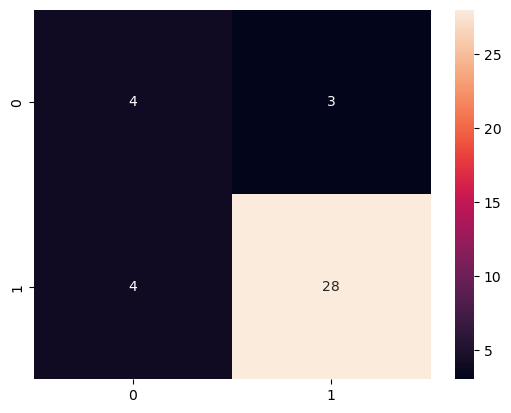

In [17]:
y_pred = gs.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True)